# Appendix C, Figure 7. Bistability in the simulations with the original rotation rate

[Skip code and jump to the figure](#Show-the-figure)

In [1]:
import warnings

warnings.filterwarnings("ignore")

from dataclasses import dataclass, field
from functools import partial
from pathlib import Path

import iris
import cmocean
import geovista as gv
import matplotlib.colors as mcol
import matplotlib.pyplot as plt
import numpy as np
import pyvista as pv
from aeolus.calc import time_mean
from aeolus.coord import isel, ensure_bounds
from aeolus.io import load_data
from aeolus.lfric import (
    add_um_height_coord,
    fix_time_coord,
    load_lfric_raw,
    ugrid_spatial,
    ugrid_spatial_mean,
)
from aeolus.model import lfric
from aeolus.plot import capitalise, figsave, subplot_label_generator, tex2cf_units, cube_minmeanmax_str
from aeolus.plot.pv import cube2d_to_mesh
from matplotlib.offsetbox import AnchoredText
from tqdm.notebook import tqdm

# PyVista display settings
pv.global_theme.trame.server_proxy_enabled = True
pv.set_jupyter_backend("trame")

Local modules

In [2]:
import paths
from common import SIMULATIONS_OLD, SPINUP_DAYS, all_sim_file_label, lfric_precip_sum, N_RES, DC

Point to the simulations with 6.1 day rotation period.

In [3]:
SIMULATIONS = SIMULATIONS_OLD

Show all simulations, using instantaneous output

In [4]:
show_sim = [*SIMULATIONS.keys()]
time_prof = "inst_diag"

## Load the data

First, load the raw instantaneous diagnostics

In [5]:
dset = {}
for sim_label in show_sim:
    dset[sim_label] = {}
    add_levs = partial(
        add_um_height_coord,
        path_to_levels_file=paths.vert / SIMULATIONS[sim_label].vert_lev,
    )

    def _combi_callback(cube, field, filename):
        [
            fix_time_coord(cube, field, filename),
            add_levs(cube, field, filename),
        ]

    fnames = sorted(
        paths.data_raw.glob(
            str(
                Path(SIMULATIONS[sim_label].work_name)
                / "*"
                / "run_lfric_atm_*"
                / f"lfric_{time_prof}.nc"
            )
        ),
        key=lambda x: int(x.parent.parent.name),
    )

    fnames = [
        i
        for i in fnames
        if int(i.parent.parent.name) * SIMULATIONS[sim_label].days_per_job > SPINUP_DAYS
    ]
    fnames = fnames[-1] # Actually need only the last file

    dset[sim_label][time_prof] = load_lfric_raw(
        fnames,
        callback=_combi_callback,
        drop_coord=["forecast_reference_time"],
    )

Also load time mean regridded data

In [6]:
dset_tmr = {}
for sim_label in show_sim:
    dset_tmr_averages = load_data(
        paths.data_proc
        / SIMULATIONS[sim_label].work_name
        / f"{SIMULATIONS[sim_label].work_name}_averages_*_time_mean_and_regr_{N_RES}.nc".lower()
    )
    dset_tmr_inst_diag = load_data(
        paths.data_proc
        / SIMULATIONS[sim_label].work_name
        / f"{SIMULATIONS[sim_label].work_name}_inst_diag_*_time_mean_and_regr_{N_RES}.nc".lower()
    )
    dset_tmr_averages = iris.cube.CubeList(
        cube
        for cube in dset_tmr_averages
        if cube.var_name
        not in [
            "tot_col_w_kinetic_energy",
            "tot_col_uv_kinetic_energy",
            "cell_area",
        ]
    )
    dset_tmr[sim_label] = dset_tmr_averages + dset_tmr_inst_diag

## Make Plots

### GeoVista Maps

In [7]:
@dataclass
class Diag:
    recipe: callable
    title: str
    units: str
    kw_plt: dict = field(default_factory=dict)


DIAGS = {
    "toa_osr": Diag(
        recipe=lambda cl: cl.extract_cube(lfric.toa_osr),
        title="TOA OSR",
        units="$W$ $m^{-2}$",
        kw_plt=dict(cmap=cmocean.cm.gray, clim=[50, 400]),
    ),
}

In [8]:
diag_keys = ["toa_osr"]
t_idx = -1
reduce_func = lambda cube: isel(cube, lfric.t, t_idx)

gv_meshes = {}
stats = {}
for sim_label in show_sim:
    gv_meshes[sim_label] = {}
    # stats[sim_label] = {}
    for diag_key in diag_keys:
        cube2d = reduce_func(DIAGS[diag_key].recipe(dset[sim_label][time_prof]))
        cube2d.convert_units(tex2cf_units(DIAGS[diag_key].units))
        gv_meshes[sim_label][diag_key] = cube2d_to_mesh(cube2d)

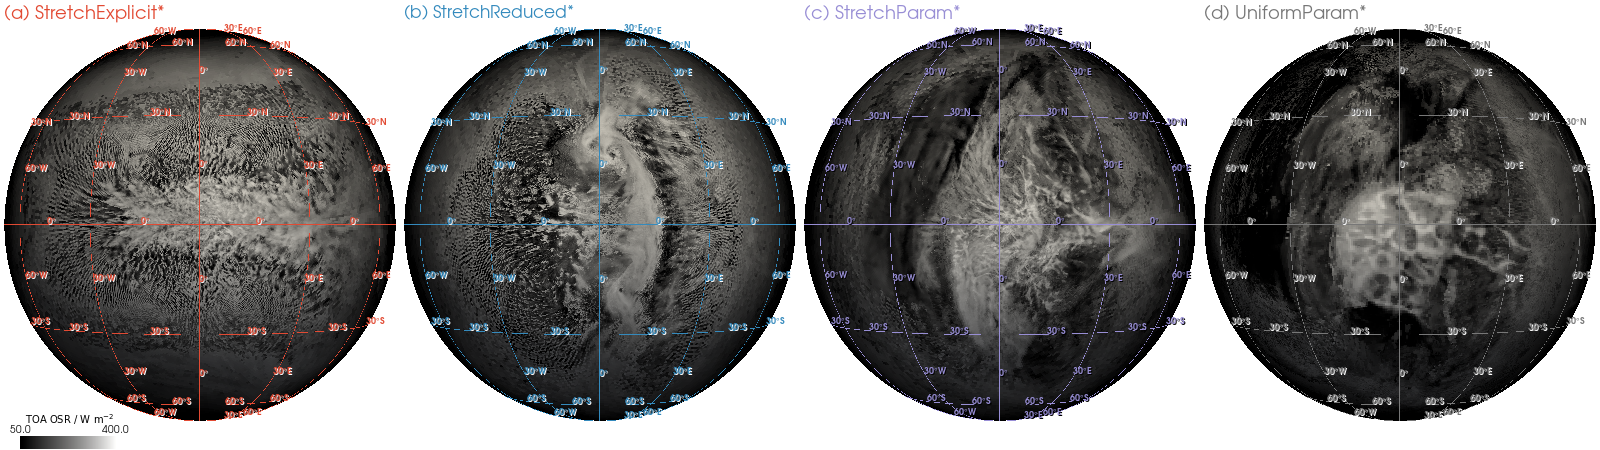

In [9]:
savefig = True
tilted = False
add_grat = True
diag_keys = ["toa_osr"]

plotter = gv.GeoPlotter(
    window_size=[400 * len(show_sim), 450 * len(diag_keys)],
    shape=(len(diag_keys), len(show_sim)),
    border=False,
)
zoom = 1.7
kw_grat = dict(
    lon_step=30,
    lat_step=30,
    mesh_args={"color": "grey"},
    point_labels_args={"shape_opacity": 0, "text_color": "grey", "shadow": True},
)
letters = subplot_label_generator()

for diag_idx, diag_key in enumerate(diag_keys):
    scalar_bar_args = {
        # "title": f"{SIMULATIONS[sim_label].title}\n{DIAGS[diag_key].title} / {DIAGS[diag_key].units}",
        "title": f"{DIAGS[diag_key].title} / {DIAGS[diag_key].units}",
        "color": "k",
        "title_font_size": 10,
        "label_font_size": 10,
        "shadow": False,
        "n_labels": 2,
        "italic": False,
        "bold": False,
        "fmt": "%.1f",
        "font_family": "arial",
        "width": 0.25,
        "vertical": False,
        "position_x": 0.05,  # 0.225
        "position_y": 0.0,  # 0.9
    }
    for sim_idx, sim_label in enumerate(show_sim):
        color = SIMULATIONS[sim_label].kw_plt["color"]
        plotter.subplot(diag_idx, sim_idx)
        plotter.add_text(
            f"({next(letters)}) {SIMULATIONS[sim_label].title}",
            position="upper_left",
            font_size=10,
            color=color,
        )
        plotter.add_mesh(
            gv_meshes[sim_label][diag_key],
            show_scalar_bar=True,  # (sim_idx == diag_idx),
            zlevel=0,
            scalar_bar_args=scalar_bar_args,
            **DIAGS[diag_key].kw_plt,
            # annotations={10**e: f"$10^{{{e}}}$" for e in range(-4, 2)},
            # annotations={
            #     stats[sim_label][diag_key][
            #         "mean"
            #     ]: f"Mean: {stats[sim_label][diag_key]['mean']:.1f}",
            # },
        )
        kw_grat["point_labels_args"]["text_color"] = color
        kw_grat["mesh_args"]["color"] = color
        if add_grat:
            plotter.add_graticule(**kw_grat)
            extra_label = "__grat"
        else:
            extra_label = ""
        if tilted:
            plotter.camera.position = (6.5, 2.5, 2.5)
            extra_label += "_tilt_view"
        else:
            plotter.view_yz(negative=False)
        plotter.camera.zoom(zoom)

plotter.show(jupyter_backend="static")

if savefig:
    imgname = (
        paths.figures
        / "drafts"
        / f"thai_hab1__{all_sim_file_label}__{time_prof}__{'_'.join(diag_keys)}{extra_label}.png"
    )
    plotter.screenshot(imgname)
    plotter.close()
    # print(f"Size: {imgname.stat().st_size / 1024:.1f} KB")

### Combine it with the regridded maps

Define coordinate points and labels

In [10]:
lons = dset_tmr[sim_label].extract(DC.relax.x)[0].coord(lfric.x).points
lats = dset_tmr[sim_label].extract(DC.relax.y)[0].coord(lfric.y).points

coord_mappings = {
    "longitude": dict(ticks=np.arange(-180, 181, 60), units="degrees"),
    "latitude": dict(ticks=np.arange(-90, 91, 30), units="degrees"),
}

Define diagnostics

In [11]:
@dataclass
class Diag:
    recipe: callable
    title: str
    units: str
    fmt: str
    kw_plt: dict = field(default_factory=dict)
    method: str = "contourf"


prec_levels = [0.1, 0.25, 0.5, 1, 2, 4, 8, 16, 32, 64]
prec_colors = cmocean.cm.rain(np.linspace(0, 1, len(prec_levels) - 1))
prec_cmap, prec_norm = mcol.from_levels_and_colors(prec_levels, prec_colors)


DIAGS = {
    "t_sfc": Diag(
        recipe=lambda cl: cl.extract_cube(lfric.t_sfc),
        title="Surface Temperature",
        units="$K$",
        method="pcolormesh",
        kw_plt=dict(
            cmap=cmocean.cm.thermal,
            vmin=180,
            vmax=290,
            rasterized=True,
        ),
        fmt="auto",
    ),
    "tot_prec": Diag(
        recipe=lfric_precip_sum,
        title="Total Precipitation",
        units="$mm$ $day^{-1}$",
        method="pcolormesh",
        kw_plt=dict(
            cmap=prec_cmap,
            norm=prec_norm,
        ),
        fmt="pretty",
    ),
}

In [12]:
diag_keys = ["t_sfc"]  # , "tot_prec"

plot_winds = ["t_sfc"]
height_constraint = iris.Constraint(**{lfric.z: 8000})
plot_w_zm_day = []

fig = plt.figure(figsize=(8, 4), layout="constrained")
subfigs = fig.subfigures(
    nrows=len(diag_keys) + 1, ncols=1, squeeze=False, height_ratios=[2/3, 1/3]
)[:, 0]
mosaic = [show_sim + ["cax"]]

subfigs[0].suptitle(
    (
        "Simulation with a rotation period of 6.1 days"
        "\n\nTOA Outgoing Shortwave Radiation [$W$ $m^{-2}$]"
    ),
    fontweight="bold",
)
ax = subfigs[0].add_subplot(111)
ax.imshow(plt.imread(imgname))
ax.axis("off")

iletters = subplot_label_generator()
[next(iletters) for _ in show_sim]  # skip first four letters
for diag_key, subfig in zip(diag_keys, subfigs[1:]):
    axd = subfig.subplot_mosaic(
        mosaic,
        width_ratios=[1] * len(show_sim) + [0.05],
        gridspec_kw={},
    )
    for sim_label in show_sim:
        ax = axd[sim_label]

        ax.set_title(
            f"({next(iletters)})",
            loc="left",
            fontdict={"weight": "bold"},
            pad=3,
        )
        ax.set_title(
            SIMULATIONS[sim_label].title,
            loc="center",
            fontdict={"weight": "bold"},
            pad=3,
            color=SIMULATIONS[sim_label].kw_plt["color"],
        )
        if diag_key == "conv_prec" and sim_label == "hab1_mod_c192s10e":
            [ax.spines[spine].set_visible(False) for spine in ax.spines]
            ax.tick_params(colors=plt.rcParams["figure.facecolor"])
            # ax.
            continue
        cube = DIAGS[diag_key].recipe(dset_tmr[sim_label])
        cube.convert_units(tex2cf_units(DIAGS[diag_key].units))
        y, x = cube.dim_coords
        if coord_mapping := coord_mappings.get(x.name()):
            x.convert_units(coord_mapping["units"])
            ax.set_xticks(coord_mapping["ticks"])
            ax.set_xlim(coord_mapping["ticks"][0], coord_mapping["ticks"][-1])
        if coord_mapping := coord_mappings.get(y.name()):
            y.convert_units(coord_mapping["units"])
            ax.set_yticks(coord_mapping["ticks"])
            ax.set_ylim(coord_mapping["ticks"][0], coord_mapping["ticks"][-1])
        if ax.get_subplotspec().is_first_col():
            ax.set_ylabel(
                f"{capitalise(y.name())} [{y.units}]", size="small", labelpad=1
            )
        elif not ax.get_subplotspec().is_last_col():
            ax.set_yticklabels([])
        if ax.get_subplotspec().is_last_row():
            ax.set_xlabel(
                f"{capitalise(x.name())} [{x.units}]", size="small", labelpad=1
            )
        ax.tick_params(labelsize="small")
        h = getattr(ax, DIAGS[diag_key].method)(
            x.points, y.points, cube.data, **DIAGS[diag_key].kw_plt
        )
        if (
            iris.util.guess_coord_axis(x) == "X"
            and iris.util.guess_coord_axis(y) == "Y"
        ):
            at = AnchoredText(
                cube_minmeanmax_str(
                    cube,
                    fmt=DIAGS[diag_key].fmt,
                    precision=1,
                    sep="\n",
                    eq_sign=": ",
                ),
                loc="lower left",
                frameon=True,
                prop={
                    "size": "xx-small",
                    "weight": "bold",
                    "color": SIMULATIONS[sim_label].kw_plt["color"],
                },
            )
            at.patch.set_facecolor(mcol.to_rgba("w", alpha=0.75))
            at.patch.set_edgecolor("none")
            ax.add_artist(at)
        if diag_key in plot_winds:
            u = dset_tmr[sim_label].extract_cube(lfric.u)
            v = dset_tmr[sim_label].extract_cube(lfric.v)
            for cube in [u, v]:
                ensure_bounds(cube, coords=("z"), model=lfric)
            u = u.extract(height_constraint)
            v = v.extract(height_constraint)
            rounded_height = round(u.coord(lfric.z).points[0])

            wspd = (u**2 + v**2) ** 0.5
            ax.streamplot(
                x.points,
                y.points,
                u.data,
                v.data,
                density=0.75,
                color=SIMULATIONS[sim_label].kw_plt["color"],
                linewidth=wspd.data / wspd.data.max(),
                arrowstyle="Fancy, head_length=0.5, head_width=0.2, tail_width=0.1",
                # broken_streamlines=False
            )
        if diag_key in plot_w_zm_day:
            cube = DIAGS["w_zm_day"].recipe(dset_tmr[sim_label])
            cube.convert_units(tex2cf_units(DIAGS["w_zm_day"].units))
            _ = ax.contourf(
                x.points, y.points, cube.data, **DIAGS["w_zm_day"].kw_plt, alpha=0.25
            )
            cntr = ax.contour(x.points, y.points, cube.data, **DIAGS["w_zm_day"].kw_plt)
            ax.clabel(cntr, fmt="%.1f")
    ttl = f"{DIAGS[diag_key].title} [{DIAGS[diag_key].units}]"
    if diag_key in plot_winds:
        ttl += f" and Wind Streamlines at {rounded_height} m"
        extra_label = f"__wind_{rounded_height:05d}m"
    elif diag_key in plot_w_zm_day:
        ttl += f" and {DIAGS['w_zm_day'].title} [{DIAGS['w_zm_day'].units}]"
        extra_label = "__w_zm_day"
    else:
        extra_label = ""
    subfig.suptitle(ttl, fontweight="bold")
    cbar = subfig.colorbar(h, cax=axd["cax"])
    if diag_key in ["tot_prec", "ls_prec", "conv_prec"]:
        cbar.ax.set_yticks(prec_levels)
        cbar.ax.set_yticklabels([str(i) for i in prec_levels])
plt.close()

# Show the figure

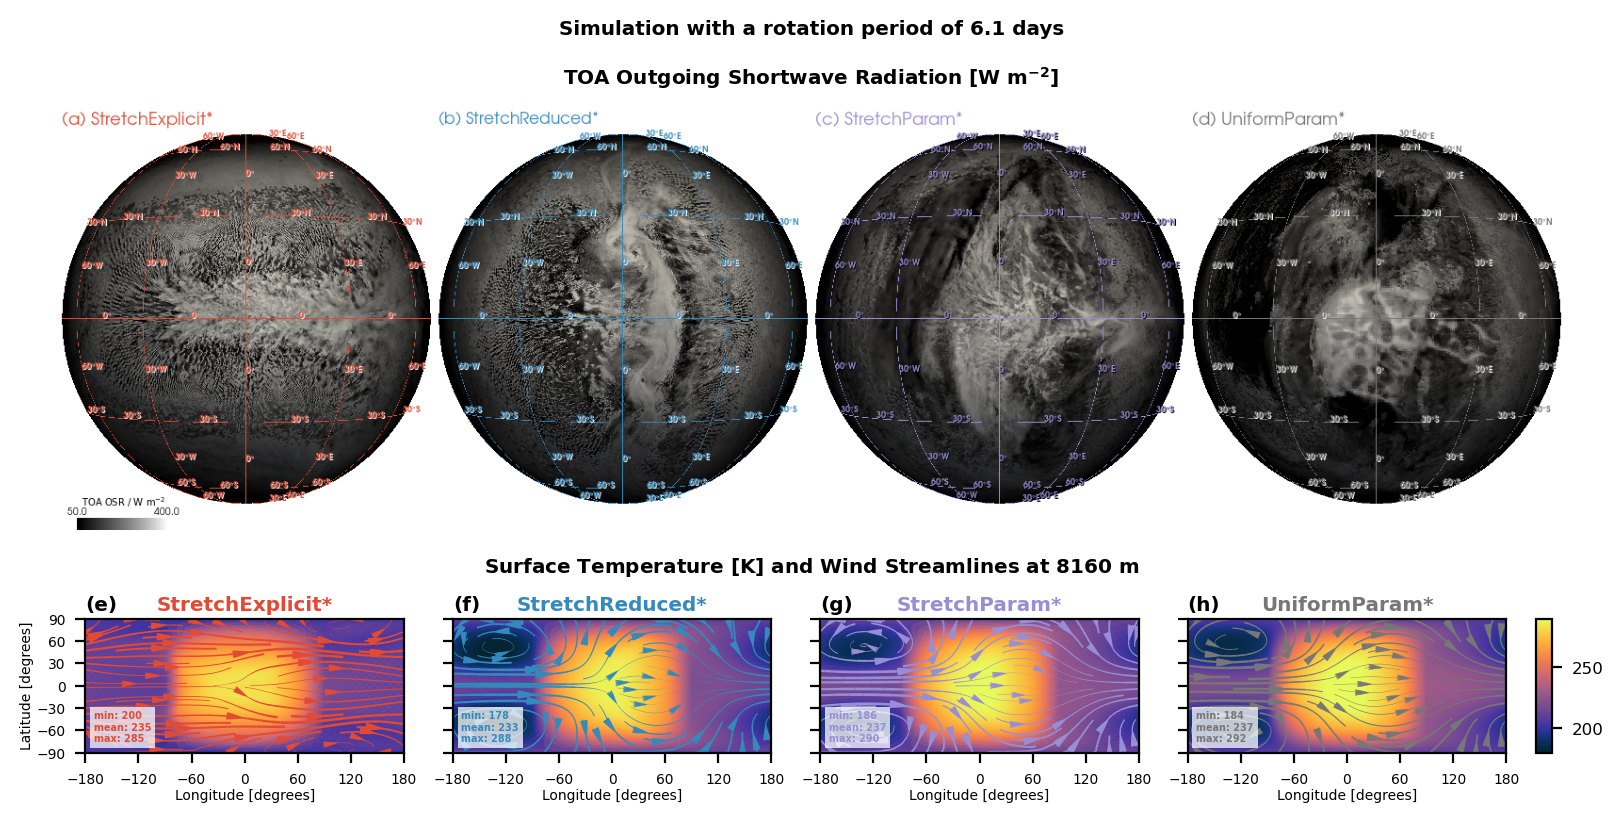

In [13]:
fig

- **Circulation regime bistability in the simulations with the rotation period set to 6.1 days.**
- **The circulation regime switches to another state when the convection scheme is switched off - compare the two leftmost columns (the StretchExplicit
and StretchReduced cases).**
- **Top panels show instantaneous top-of-atmosphere outgoing shortwave radiation.**
- **Bottom panels show the time mean surface temperature in $K$ overlaid by streamlines of the horizontal wind at $\approx$8 km above the surface.**

In [14]:
# and save it
figsave(
    fig,
    paths.figures
    / f"thai_hab1__{all_sim_file_label(show_sim)}__{time_prof}__toa_osr__{'_'.join(diag_keys)}{extra_label}",
)